<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#¿Qué-es-una-Serie-Temporal?" data-toc-modified-id="¿Qué-es-una-Serie-Temporal?-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>¿Qué es una Serie Temporal?</a></span></li><li><span><a href="#Exploración-de-los-datos" data-toc-modified-id="Exploración-de-los-datos-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploración de los datos</a></span><ul class="toc-item"><li><span><a href="#Conversión-de-la-columna-date-a-datetime" data-toc-modified-id="Conversión-de-la-columna-date-a-datetime-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Conversión de la columna date a datetime</a></span></li><li><span><a href="#Chequeemos-los-nulos." data-toc-modified-id="Chequeemos-los-nulos.-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Chequeemos los nulos.</a></span></li></ul></li><li><span><a href="#Componentes-de-una-Serie-Temporal" data-toc-modified-id="Componentes-de-una-Serie-Temporal-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Componentes de una Serie Temporal</a></span><ul class="toc-item"><li><span><a href="#Estacionalidad" data-toc-modified-id="Estacionalidad-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Estacionalidad</a></span></li><li><span><a href="#Estacionaridad" data-toc-modified-id="Estacionaridad-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Estacionaridad</a></span></li><li><span><a href="#Comparativa-estacionalidad-vs-estacionaridad" data-toc-modified-id="Comparativa-estacionalidad-vs-estacionaridad-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Comparativa estacionalidad vs estacionaridad</a></span></li></ul></li><li><span><a href="#Autocorrelación" data-toc-modified-id="Autocorrelación-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Autocorrelación</a></span></li><li><span><a href="#Modelo-ARIMA" data-toc-modified-id="Modelo-ARIMA-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Modelo ARIMA</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]


## Para sacar los componentes de la serie temporal
################################################################
from statsmodels.tsa.seasonal import seasonal_decompose


## Para calcular la estacionaridad de nuestras series temporales
################################################################
from statsmodels.tsa.stattools import adfuller

## Para calcular la autocorrelación en la serie temporal
################################################################
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

## Para ajustar los modelos predictivos
################################################################
from statsmodels.tsa.arima.model import ARIMA
from itertools import product

## Para las metricas del modelo
################################################################
from sklearn.metrics import mean_squared_error

## Para ignorar los warnings
################################################################
import warnings
warnings.filterwarnings("ignore")

In [2]:
#!pip install statsmodels

# ¿Qué es una Serie Temporal?

Una Serie Temporal, es una sucesión de datos medidos en determinados momentos y ordenados cronológicamente. Los datos pueden estar espaciados a intervalos iguales (como la temperatura en un observatorio meteorológico en días sucesivos al mediodía) o desiguales (como el peso de una persona en sucesivas mediciones en el consultorio médico, la farmacia, etc.).

Cuando estamos trabajando con Series Temporales nos tenemos que hacer las siguientes preguntas: 

- ¿Es estacionario?

- ¿Hay una estacionalidad?

- ¿Los datos están autocorrelacionados?

# Exploración de los datos

In [2]:
df = pd.read_csv("data/caramelos.csv", index_col = 0)
df.head()

,date,IPG3113N
0,1972-01-01,85.598809
1,1972-02-01,71.741404
2,1972-03-01,65.948809
3,1972-04-01,64.490724
4,1972-05-01,64.933842


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
IPG3113N,564.0,101.136666,18.131158,50.680157,88.344728,102.777853,114.928399,139.302096


## Conversión de la columna date a datetime
Para trabajar con Series Temporales debemos asegurarnos de que la columna de fecha esta en formato `datetime`, que este como índice y debe tener alguna frecuencia. Veamos como hacerlo: 

In [4]:
df.dtypes

date         object
IPG3113N    float64
dtype: object

In [5]:
# colocamos la columna a datetime y la ponemos como índice
df.index = pd.to_datetime(df["date"])
df.head()

,date,IPG3113N
date,,
1972-01-01,1972-01-01,85.598809
1972-02-01,1972-02-01,71.741404
1972-03-01,1972-03-01,65.948809
1972-04-01,1972-04-01,64.490724
1972-05-01,1972-05-01,64.933842


In [6]:
# veamos como es nuestro índice
df.index

DatetimeIndex(['1972-01-01', '1972-02-01', '1972-03-01', '1972-04-01',
               '1972-05-01', '1972-06-01', '1972-07-01', '1972-08-01',
               '1972-09-01', '1972-10-01',
               ...
               '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01',
               '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01'],
              dtype='datetime64[ns]', name='date', length=564, freq=None)

Si nos fijamos nuestra columna de momento no tiene frecuencia. Para cambiarlo usaremos el método `infer_freq` de pandas

In [7]:
df.index.freq = pd.infer_freq(df.index)
df.index

DatetimeIndex(['1972-01-01', '1972-02-01', '1972-03-01', '1972-04-01',
               '1972-05-01', '1972-06-01', '1972-07-01', '1972-08-01',
               '1972-09-01', '1972-10-01',
               ...
               '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01',
               '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01'],
              dtype='datetime64[ns]', name='date', length=564, freq='MS')

Si nos fijamos ahora Pandas automaticamente ha detectado la frecuencia, es de día. 

In [8]:
df.head()

,date,IPG3113N
date,,
1972-01-01,1972-01-01,85.598809
1972-02-01,1972-02-01,71.741404
1972-03-01,1972-03-01,65.948809
1972-04-01,1972-04-01,64.490724
1972-05-01,1972-05-01,64.933842


In [9]:
# por último eliminamos la columna de DATE que ya no nos hace falta. 
df.drop(columns=['date'], inplace=True)
df.head()

,IPG3113N
date,
1972-01-01,85.598809
1972-02-01,71.741404
1972-03-01,65.948809
1972-04-01,64.490724
1972-05-01,64.933842


## Chequeemos los nulos. 

🚨🚨🚨 No podremos tenere nulos en el *dataframe*

In [10]:
df.isnull().sum()

IPG3113N    0
dtype: int64

In [11]:
df.isnull().sum()

IPG3113N    0
dtype: int64

In [12]:
df.columns = ["valores"]
df.head()

,valores
date,
1972-01-01,85.598809
1972-02-01,71.741404
1972-03-01,65.948809
1972-04-01,64.490724
1972-05-01,64.933842


# Componentes de una Serie Temporal

El análisis clásico de series temporales considera que una serie temporal queda formada por cuatro
componentes:

- `Tendencia o Estacionaridad`: movimiento regular de la serie, a largo plazo.


- `Variaciones estacionales`: oscilaciones a corto plazo del período regular, de duración menor o igual a un año.


- `Variaciones cíclicas`: movimientos a medio plazo (superior a un año) en torno a la tendencia cuyo período y amplitud pueden presentar cierta regularidad.


- `Ruido Blanco o residuos`: consisten en movimientos irregulares y pasajeros provocados por factores esporádicos e imprevisibles. Son efectos impredecibles que no son asignables a ninguna de las componentes anteriores, por lo que constituyen el residuo que queda cuando se estiman las otras componentes.

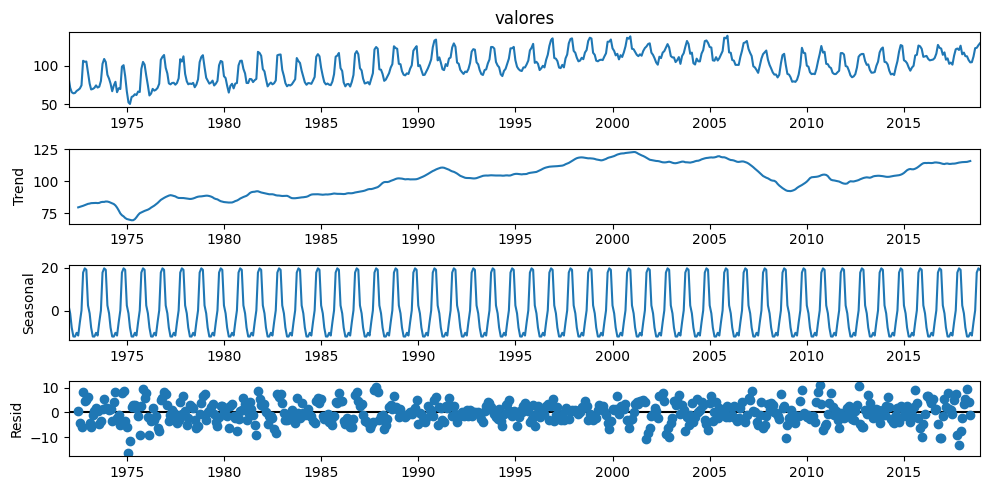

In [13]:
res = seasonal_decompose(df.valores, model="additive")
res.plot();

## Estacionalidad


Un patrón estacional se produce cuando una serie temporal se ve afectada por factores estacionales, como la época del año o el día de la semana. La estacionalidad tiene siempre una frecuencia fija y conocida.



In [14]:
df2 = df.copy()
df2.head()

,valores
date,
1972-01-01,85.598809
1972-02-01,71.741404
1972-03-01,65.948809
1972-04-01,64.490724
1972-05-01,64.933842


In [15]:
df2["year"] = df2.index.year
df2["month"] = df2.index.month
df2.head()

,valores,year,month
date,,,
1972-01-01,85.598809,1972,1
1972-02-01,71.741404,1972,2
1972-03-01,65.948809,1972,3
1972-04-01,64.490724,1972,4
1972-05-01,64.933842,1972,5


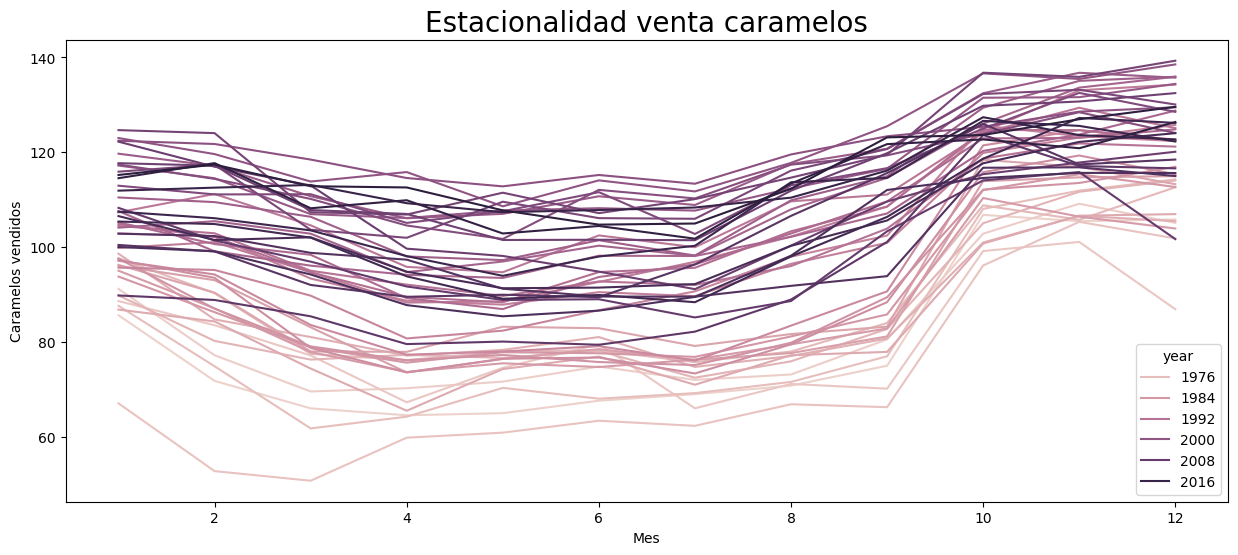

In [16]:
fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(x = 'month', y = 'valores', data = df2, hue=df2['year'])
ax.set_title('Estacionalidad venta caramelos', fontsize = 20, loc='center')
ax.set_xlabel('Mes')
ax.set_ylabel('Caramelos vendidos');



## Estacionaridad

Existe una tendencia cuando hay un aumento o una disminución a largo plazo en los datos. No tiene por qué ser lineal. A veces se dice que una tendencia "cambia de dirección" cuando puede pasar de una tendencia creciente a una tendencia decreciente. Se puede decir que una serie es estacionaria cuando **su media y su varianza no están en función del tiempo**, es decir, son constantes en el tiempo.

La estacionariedad es importante porque la mayoría de los métodos estadísticos para realizar análisis y predicciones se basan en la suposición de que las propiedades estadísticas de la serie (media, varianza, correlación, etc.) son constantes en el tiempo.

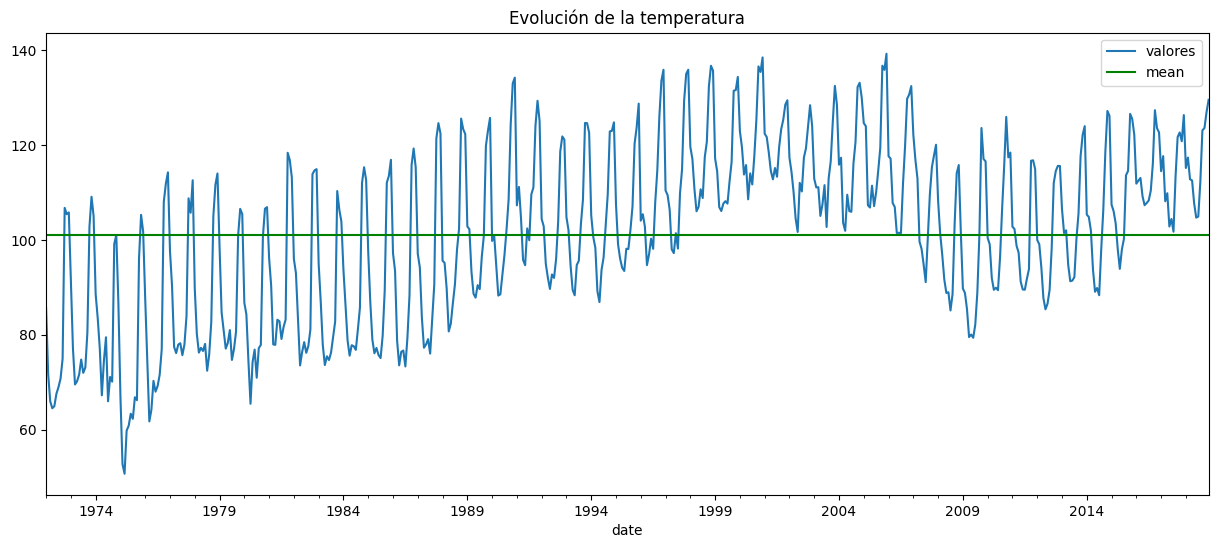

In [17]:
df.plot(figsize=(15,6))
plt.title("Evolución de la temperatura")
plt.axhline(df.valores.mean(), c="g", label="mean")
plt.legend();


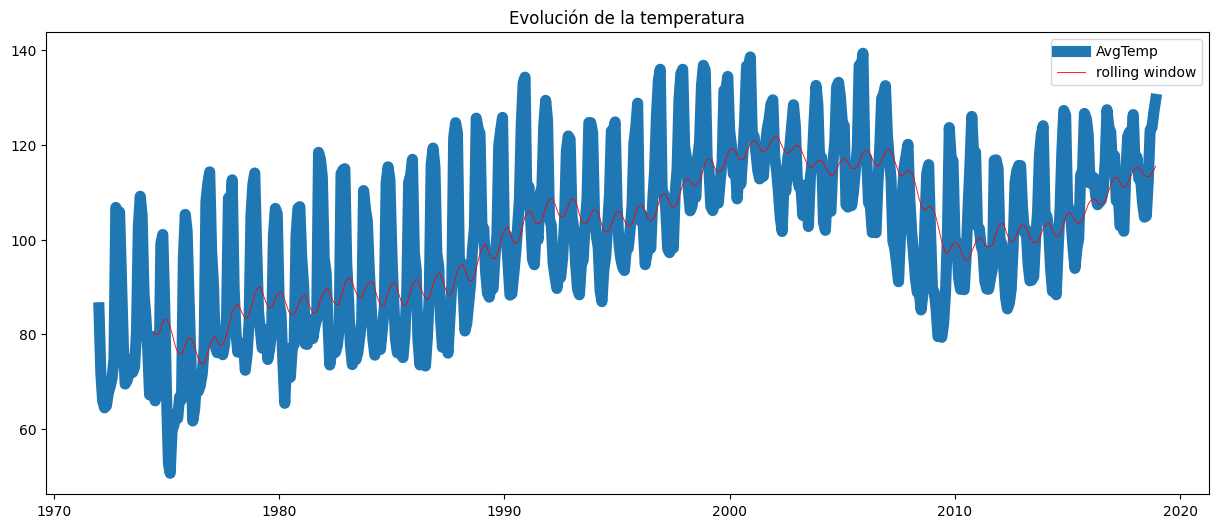

In [18]:
plt.figure(figsize=(15,6))
plt.title("Evolución de la temperatura")

plt.plot(df["valores"], label="AvgTemp", linewidth=8)
plt.plot(df.rolling(window =30).mean(), label="rolling window", c= "r", linewidth = 0.6)

plt.legend();

hay una tendencia más clara en este caso -> no son estacionarios.

Al plotear la media junto con los puntos de datos originales, podemos ver algo de tendencia a lo largo del tiempo. Pero esto nos puede convencer poco, también podemos hacer el test de ADFuller

In [19]:
res_ad = adfuller(df["valores"])
res_ad

(-1.776015307501608,
 0.3924327500714014,
 14,
 549,
 {'1%': -3.4423174665535385,
  '5%': -2.866818952732754,
  '10%': -2.569581505602171},
 3094.828881317046)

In [20]:
# pongamosle etiquetas a los resultados
print('ADF Statistic:', res_ad[0])
print('p-value:', res_ad[1])
print('Critical Values:')
for key, value in res_ad[4].items():
    print( "\t",  key, round(value, 2))

ADF Statistic: -1.776015307501608
p-value: 0.3924327500714014
Critical Values:
	 1% -3.44
	 5% -2.87
	 10% -2.57


**¿Cuáles son las conclusiones de esta prueba?**

A partir de los resultados del test de Dickey Fuller podemos observar dos cosas:

- Si adf > valores_críticos  ==> DATOS NO ESTACIONARIOS


- pvalue> 0.05  ==> DATOS NO ESTACIONARIOS


Nuestro datos son no estacionarios.

## Comparativa estacionalidad vs estacionaridad

TypeError: boxplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given

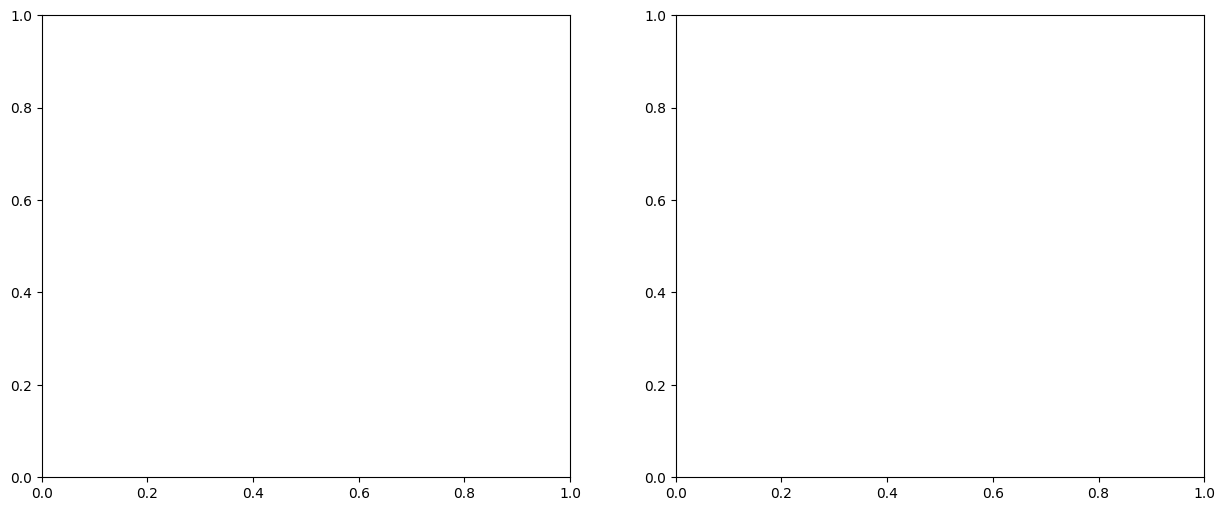

In [21]:
# nos creamos una lista con las columnas de tiempo
tiempo = df2.columns.drop("valores")

componentes = ["Estacionaridad", "Estacionalidad"]

#iniciamos los subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# hacemos nuestro for para no repetir lineas de código
for i, col in enumerate(tiempo):
    sns.boxplot(df2[col], df2["valores"], ax=ax[i])
    ax[i].set_title(componentes[i], fontsize = 20, loc='center')
    ax[i].set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
    ax[i].set_ylabel('caramelos', fontsize = 16)
plt.show()

# Autocorrelación

La autocorrelación es un tipo de dependencia temporal. En concreto, la autocorrelación se produce cuando una serie temporal está relacionada linealmente con una versión retardada de la misma. 

**Se trata de una medida de la correlación de los datos de la serie temporal en un momento dado con los valores pasados, lo que tiene enormes implicaciones en muchos sectores. Por ejemplo, si nuestros datos de ventas de caramelos tienen una fuerte autocorrelación, podemos suponer que un número elevado de ventas hoy sugiere una fuerte probabilidad de que también sea elevado mañana**



Quizás el aspecto más convincente del análisis de autocorrelación es cómo puede ayudarnos a descubrir patrones ocultos en nuestros datos y a seleccionar los métodos de previsión correctos. En concreto, podemos utilizarlo para ayudar a identificar la estacionalidad y la tendencia en nuestros datos de series temporales. Además, el análisis conjunto de la función de autocorrelación (ACF) y la función de autocorrelación parcial (PACF) es necesario para seleccionar el modelo ARIMA adecuado para la predicción de series temporales.

- `Auto-correlación`: la correlación entre dos momentos/instantes de tiempo.


- `Auto-correlación parcial`: es una medida de la correlación entre observaciones de una serie de tiempo que se encuentran separadas por k unidades de tiempo (yt y yt-k), después de ajustarse para la presencia de los demás términos de desfase más corto (yt-1, yt-2, ..., yt–k–1).

![auto](https://github.com/Ironhack-Part-Time-Enero2022/apuntes-clases/blob/master/semana-20/imagenes/autocorrelation-anatomy-python.jpg?raw=true)

In [22]:
# evaluemos la autocorrelación
for i in range(20):
    print(f"{i} mes Lag: ", df['valores'].autocorr(lag=i))

0 mes Lag:  1.0
1 mes Lag:  0.8781481101423911
2 mes Lag:  0.6925185799137717
3 mes Lag:  0.4673131980727547
4 mes Lag:  0.3028916559199807
5 mes Lag:  0.19057115878841185
6 mes Lag:  0.15964872008854095
7 mes Lag:  0.1773058737351653
8 mes Lag:  0.2810463200075143
9 mes Lag:  0.43494766610338065
10 mes Lag:  0.6516259410652507
11 mes Lag:  0.8298841367466402
12 mes Lag:  0.9320875019305085
13 mes Lag:  0.8200034875529818
14 mes Lag:  0.6395428370211454
15 mes Lag:  0.4119321847937757
16 mes Lag:  0.24954306217038077
17 mes Lag:  0.1396272147567246
18 mes Lag:  0.10597695223729853
19 mes Lag:  0.12356964733844314


Veamoslo visualmente, los gráficos generados a partir de estas funciones se denominan correlogramas, los cuales contienen bandas con un intervalo de confianza del 95%.

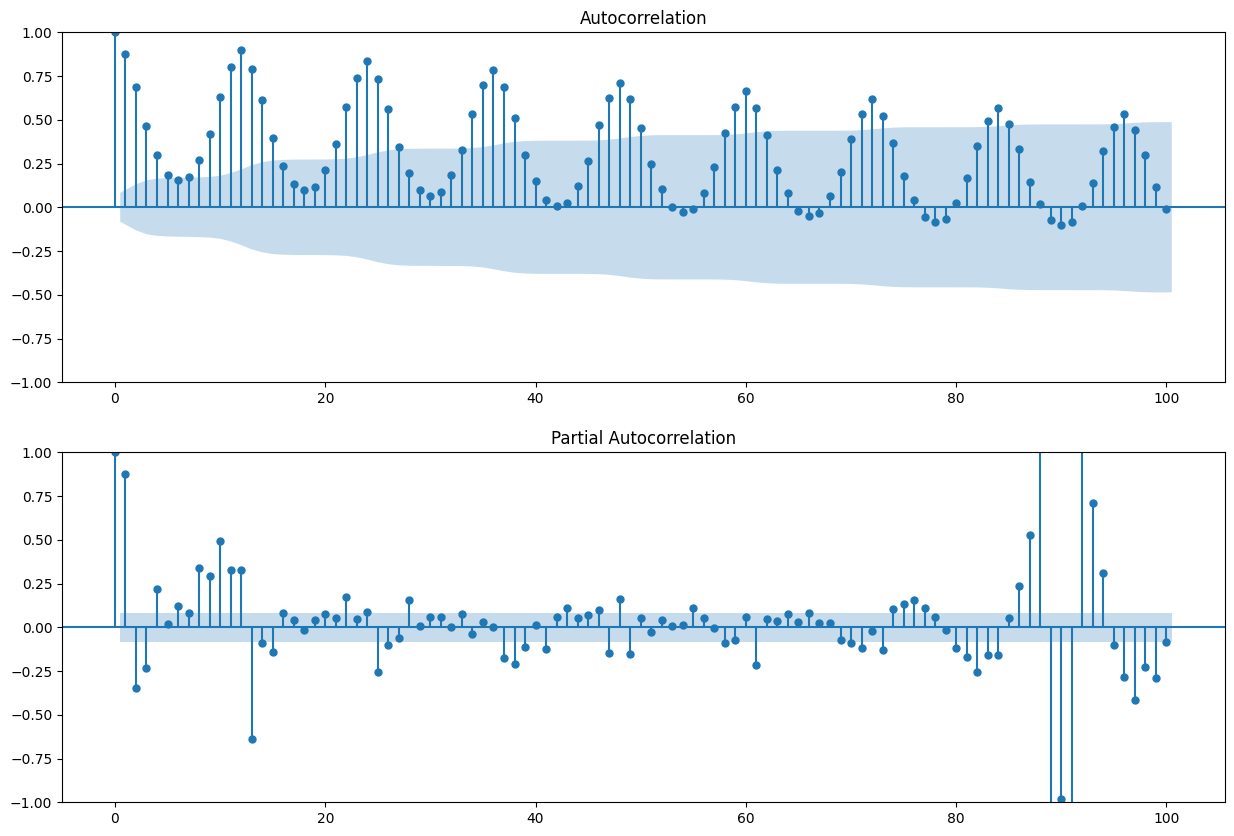

In [24]:
fig, axes = plt.subplots(2, 1, figsize=(15,10))
plot_acf(df, lags=100, ax= axes[0])
plot_pacf(df, lags=100, ax= axes[1]);

- autocorrelation : P -> número de meses que tengo en cuenta para la predicción (media)
- partial autocorrelation: Q -> cuanto se desvía cada dato respecto a la media general (desviación)

al ser no estacionario, hay que "forzar" la estacionaridad, como forzamos que los datos sean normales en la regresión lineal.
- esto es el parámetro D -> tipo de transformación que le hacemos a la recta para aplanar la tendencia.
<br> el máximo valor que tomará es 2.

# Modelo ARIMA

ARIMA (*AutoRegresive Integrated Moving Average*), deriva de sus tres componentes 

- `Autorregresivo(AR)`: la variable dependiente depende de sí misma en un período de tiempo t. **Será la `p` y lo sacaremos de la gráfica de autocorrelación**. En otras palabras, el modelo autorregresivo se basa en la idea de que la observación actual puede explicarse con valores pasados. Estos modelos se denotan como AR(p) siendo p el número de muestras que explican la muestra actual. Es decir, un AR(1) quiere decir que sólo la muestra anterior y el ruido contribuye a la salida. Un AR(2) las dos anteriores y el ruido, etc. 



- `Integrado(I)`: es el número de diferencias no estacionales **los valores normalmente no deben ser más de dos por norma general**, es decir, se trata del número de diferencias en unidades de tiempo necesarias para obtener la estacionarieda. Este parámetro se corresponde con el grado de la tendencia de la serie (la diferenciación de primer orden representa las tendencias lineales, la diferenciación de segundo orden representa las tendencias cuadráticas, etc.).

- `Media móvil(MA)`: los retrocesos son representados por procesos aleatorios. **Será la `q` y lo sacaremos de la gráfica de autocorrelación parcial**. Es decir, consiste en realizar una aproximación a la serie utilizando únicamente ruido blanco.


Lo primero que tenemos que hacer es separar nuestros datos en *train* y *test*, para seguir con buenas prácticas y ver si nuestras predicciones están *overfiteadas* 

In [25]:
y_test = df["valores"][-30:]
y_train = df["valores"][:-30]

In [26]:
ps = range(7)
ds = range(1,3)
qs = range(6)

parameters = list(product(ps,ds, qs))
print(parameters)

[(0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 1, 5), (0, 2, 0), (0, 2, 1), (0, 2, 2), (0, 2, 3), (0, 2, 4), (0, 2, 5), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 1, 4), (1, 1, 5), (1, 2, 0), (1, 2, 1), (1, 2, 2), (1, 2, 3), (1, 2, 4), (1, 2, 5), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 1, 3), (2, 1, 4), (2, 1, 5), (2, 2, 0), (2, 2, 1), (2, 2, 2), (2, 2, 3), (2, 2, 4), (2, 2, 5), (3, 1, 0), (3, 1, 1), (3, 1, 2), (3, 1, 3), (3, 1, 4), (3, 1, 5), (3, 2, 0), (3, 2, 1), (3, 2, 2), (3, 2, 3), (3, 2, 4), (3, 2, 5), (4, 1, 0), (4, 1, 1), (4, 1, 2), (4, 1, 3), (4, 1, 4), (4, 1, 5), (4, 2, 0), (4, 2, 1), (4, 2, 2), (4, 2, 3), (4, 2, 4), (4, 2, 5), (5, 1, 0), (5, 1, 1), (5, 1, 2), (5, 1, 3), (5, 1, 4), (5, 1, 5), (5, 2, 0), (5, 2, 1), (5, 2, 2), (5, 2, 3), (5, 2, 4), (5, 2, 5), (6, 1, 0), (6, 1, 1), (6, 1, 2), (6, 1, 3), (6, 1, 4), (6, 1, 5), (6, 2, 0), (6, 2, 1), (6, 2, 2), (6, 2, 3), (6, 2, 4), (6, 2, 5)]


convergencia de las variables predictoras -> por eso se pone el try / except
<br> si tienes pocos datos pero con variables muchas variablres predictoras -> dará error
<br> en el caso de una serie temporal, es que los hiperparámetros son demasiado altos

In [27]:
%%time
rmse = []
order = []
for p, d, q in tqdm(parameters):
    try:
        modelo=ARIMA(y_train, order=(p, d, q)).fit()
        pred = modelo.predict(start=len(y_train), end=len(df) -1)
        error = np.sqrt(np.mean(mean_squared_error(y_test, pred)))
        rmse.append(error)
        order.append((p,d, q))
    except: 
        continue



100%|██████████| 84/84 [00:38<00:00,  2.16it/s]

CPU times: user 3min 5s, sys: 16.1 s, total: 3min 21s
Wall time: 38.9 s


In [28]:
# veamos los resultados de todos los modelos
results = pd.DataFrame({"RMSE": rmse, "order": order})
results.sort_values(by="RMSE", inplace=True)
results.head()

,RMSE,order
53,3.904878,"(4, 1, 5)"
64,4.150829,"(5, 1, 5)"
41,4.324953,"(3, 1, 5)"
39,4.627370,"(3, 1, 3)"
27,4.638091,"(2, 1, 3)"


me equivoco en 3.90 caramelos al día -> aceptable

In [29]:
# fiteamos el modelo con los valores obtenidos de la tabla anterior y predecimos

modelo=ARIMA(y_train, order=(4, 1, 5)).fit()
pred = pd.DataFrame(modelo.predict(start=len(y_train), end=len(df) -1))

In [30]:
fecha = pd.date_range("2016-07-01", periods=30, freq="MS")
fecha

DatetimeIndex(['2016-07-01', '2016-08-01', '2016-09-01', '2016-10-01',
               '2016-11-01', '2016-12-01', '2017-01-01', '2017-02-01',
               '2017-03-01', '2017-04-01', '2017-05-01', '2017-06-01',
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01',
               '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [32]:
pred.index = fecha

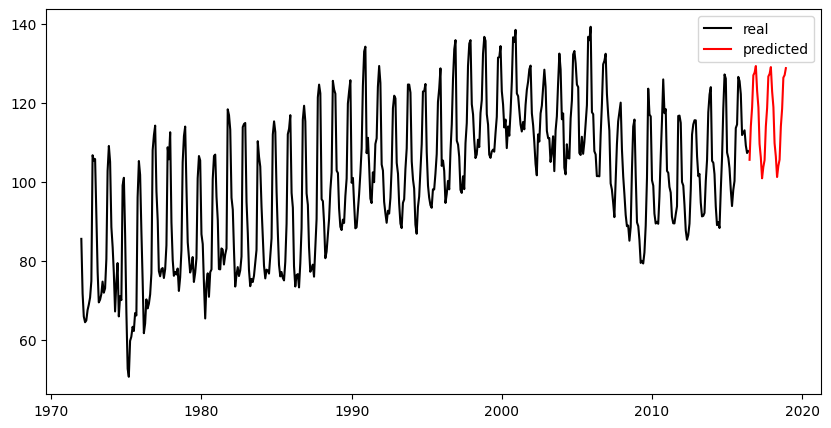

In [33]:
# veamos graficamente las predicciones

plt.plot(y_train, c = "black")
plt.plot(pred, c = "r")
plt.legend(["real", "predicted"]);

In [35]:
# añadimos al df de las predicciones los valores reales para compararlos con los predichos

pred["real_test"] = y_test

In [36]:
pred.head()

,predicted_mean,real_test
2016-07-01,105.618647,108.329463
2016-08-01,114.136018,110.411130
2016-09-01,118.946179,116.116339
2016-10-01,127.017392,127.385243
2016-11-01,127.716840,123.605806


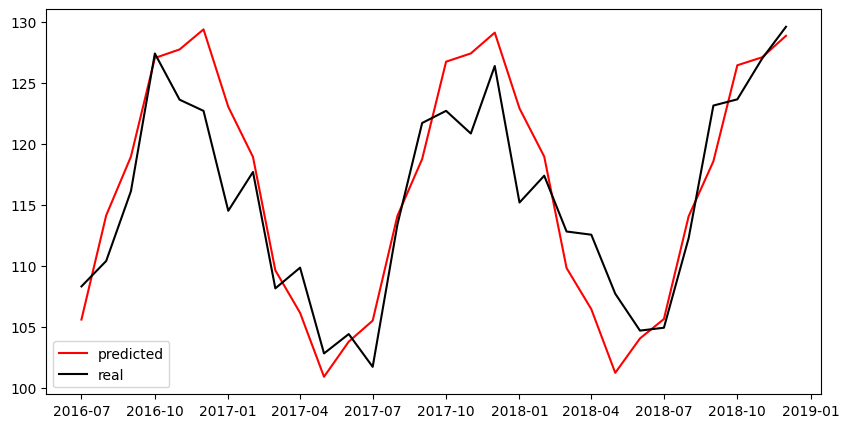

In [37]:
# vamos a comparar nuestros valores reales con los predichos

plt.plot(pred['predicted_mean'], c = "red")
plt.plot(pred["real_test"], c = "black")
plt.legend(["predicted", "real"]);

**Vamos a hacer predicciones más allá de los datos que tenemos, en concreto intentaremos predecir los siguientes doce meses**

In [ ]:
fecha2 = pd.date_range("2019-01-01", periods=12, freq="MS")
fecha2

DatetimeIndex(['2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [ ]:
pred2 = pd.DataFrame(modelo.predict(start=len(df) , end=len(df)  + 12))
pred2.head()

,predicted_mean
2019-01-01,122.765267
2019-02-01,118.981445
2019-03-01,110.021660
2019-04-01,106.756783
2019-05-01,101.576605


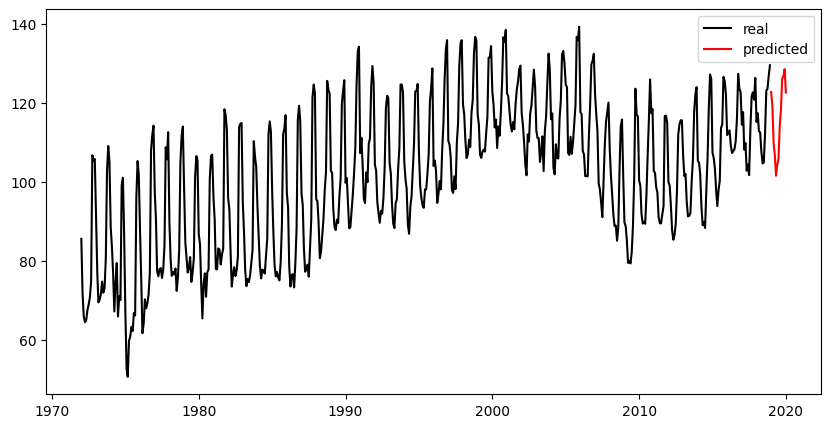

In [ ]:
# ploteamos los resultados
plt.plot(df, c = "black")
plt.plot(pred2, c = "r")
plt.legend(["real", "predicted"]);

Hagamos zoom sobre los ultimos meses de la gráfica

In [ ]:
df2 = df[df.index.year > 2017]
df2.head()

,valores
date,
2018-01-01,115.193151
2018-02-01,117.385772
2018-03-01,112.821765
2018-04-01,112.560408
2018-05-01,107.733546


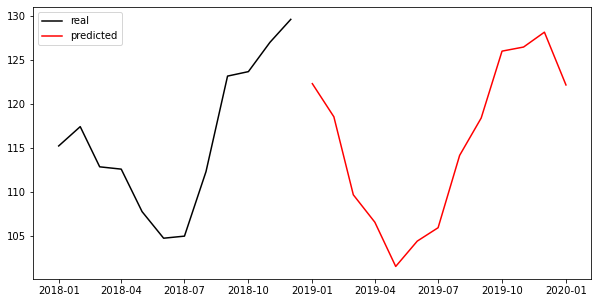

In [ ]:
plt.plot(df2, c = "black")
plt.plot(pred2, c = "red")
plt.legend(["real", "predicted"]);